In [1]:
# COMMENT OUT
import sys
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/IPython/extensions')

# Automated Chest X-ray Report Generation

## Motivation
Gathering manually annotated images for the purpose of training a predictive model is far more challenging in the medical domain than for natural images as it requires the expertise of qualified radiologists. Instead, we can use past radiological exams and their corresponding reports to develop a framework that can learn to automatically predict reports for new images.

## Learning Framework
The learning framework is based on the __[neural image caption (NIC) model of Vinyals et al.](https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Vinyals_Show_and_Tell_2015_CVPR_paper.html)__, where a word-level language generation model is conditioned on image features. In this implementation, the X-ray image features for each input image are derived from a pre-trained classification network (GoogLeNet pretrained on the ImageNet dataset), and passed through a fully-connected layer to the language model (LSTM recurrent neural net).

<img src="diagrams/chestx_caption_model.png" width="800">


## Data
We will be using a publicly available dataset from OpenI, specifically the Indian U. Chest X-ray Collection which can be accessed __[here](https://openi.nlm.nih.gov/gridquery.php?q=&it=xg&coll=cxr)__. This dataset consists of 3,955 radiology reports from the Indiana Network for Patient Care, and 7,470 associated chest x-ray images from the hospitals’ picture archiving systems. They have all been fully anonymised to remove patient names. Reports are typically made up of 'Indication' (symptoms), 'Findings' (visual features noted by the radiologist in the X-ray scan) and 'Impression' (pathology diagnosis). Of the 7,470 X-ray exams:
- 876 are missing 'Findings'
- 10 are missing 'Impressions'
- 40 are missing both

In addition, each exam has MeSH (medical subject heading) captions, which are manual annotations made by radiologists from a set of vocabulary controlled terms, mainly for the purpose of image retrieval. I took the liberty of removing the exams that are either missing MeSH terms, or missing both findings and impressions. 

The x-ray images are provided in jpg format, with sizes varying from 512x420 to 512x624.

The format of the data, which includes the image ids, MeSH terms and text reports are in a json which looks like this:
<img src="diagrams/data_format.png" width="800">

You can have a look at samples of the json dictionary and corresponding images below.

In [8]:
import numpy as np
import os
import json
import random
# random.seed(123)
# np.random.seed(123)
import matplotlib.pyplot as plt
%matplotlib inline

imagedir = './data/chestx/jpeg_images/'

Total exams:  7244
{u'mesh caption': u'normal', u'text report': [u' ', u'heart size is normal and the lungs are clear . no effusions .'], u'imageid': u'CXR2996_IM-1381-1001'}
Image size:  (433, 512, 3)


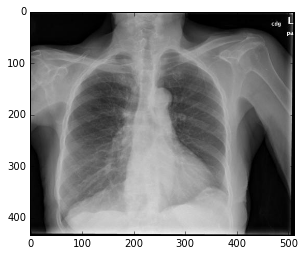

In [9]:
dataset = json.load(open("all_reports.json"))
print 'Total exams: ', len(dataset)
sample = random.choice(dataset)
print sample
im = plt.imread(imagedir + sample['imageid'] + '.jpg')
plt.imshow(im)
print 'Image size: ', im.shape

# Train/Test Split
Since we may want to test different models in the next notebooks, it's best to do the train/test split now so that we are always using the same sets for training/testing the models. This may not be the best way, I'm open to suggestions...

In [4]:
from sklearn import model_selection

train1, test = model_selection.train_test_split(dataset, train_size=0.8, random_state=42)
train, val = model_selection.train_test_split(train1, train_size=0.8, random_state=42)
print(len(train), len(test), len(val))

(4636, 1449, 1159)


/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
for el in train:
    el['split'] = 'train'
for el in test:
    el['split'] = 'test'
for el in val:
    el['split'] = 'val'
all_reports_split = train + test + val

with open('all_reports_train_test_split.json', 'w') as outfile:
    json.dump(all_reports_split, outfile)